In [1]:
# you might want to add the path to your Tequila repo
# if add it here
path_to_tequila = '/home/jsk/projects/OpenVQE'
if path_to_tequila is not None:
    import sys
    sys.path.append(path_to_tequila)

# Tequila Tutorial: 
## Handling Optimizers, Initializing parametrized circuits

In [2]:
# Import everything we need here
from openvqe import gates, paulis, Variable, Objective, scipy_optimizers, Variable
import numpy

In the following example we will optimize a simple two qubit VQE with an Ansatz that is parametrized by two parameters.
The Hamiltonian is also very simple and defined in the box below.
$$ H = \sigma_x(1) + c \sigma_z(1) - \sigma_z(0)$$

In [3]:
c = 0.001
H = paulis.X(1) + 0.0*c*paulis.Z(1)

Lets take a look at the spectrum of this very simple Hamiltonian

In [4]:
matrix = H.to_matrix()
e, v = numpy.linalg.eigh(matrix)
e

array([-1., -1.,  1.,  1.])

And here we initialize our Ansatz circuit which is parametrized by a and b.<br>

We show to ways to initialize Variables:
Variable a is initialized with a convenience string based initialization (the value will be set to 0.0, see further down how to change it) <br>
Variable b is initialized as Variable which allows you to scale it when initializing gates<br>


The Ansatz has no specific meaning and it is more to show different ways how to deal with variables.
See for instance that you can scale them and use the same variable in multiple gates.
What essentially happens is, that the variable $a$ needs to switch on the control qubit
and variable $b$ finds the effective one qubit minimum

In [5]:
b = Variable(name="b", value=0.0)

U = gates.Ry(target=0, angle='a')
U += gates.Ry(target=1, control=0, angle=b/2)
U += gates.X(target=1)
U += gates.Ry(target=1, control=0, angle=-b/2)
U += gates.Rx(target=0,angle=1.234)


In [6]:
print(U)

circuit: 
Ry(target=(0,), parameter=a)
Ry(target=(1,), control=(0,), parameter=(b)/(2))
X(target=(1,), parameter=None)
Ry(target=(1,), control=(0,), parameter=((b)*(-1.0))/(2))
Rx(target=(0,), parameter=+1.2340)



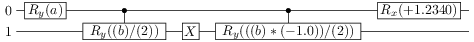

In [7]:
# this is just to show the circuit. You will need the 'wand' package which is no dependency for tequila
# since it is only used here to display pdf files in jupyter
# it's easy to install with pip install wand
# your system also needs the 'qpic' packange (pip install qpic)
# and 'pdflatex'
# If those things are not there it doesn't matter, since this cell is only to display the picture (looks nicer than the printout)
from openvqe.circuit import qpic
qpic.export_to_pdf(circuit=U, filename="example_circuit")
from wand.image import Image as WImage
img = WImage(filename='example_circuit.pdf', resolution=100) # bigger
img

In the next box we form an objective out of our Hamiltonian and our Ansatz and pass it down to the optimizer.
In the following boxes we show how the results of the optimizer can be plotted

See farther below for some small exercises and additional information

In [8]:
initial_values = {'a':0.1, 'b':0.1}
O = Objective(unitaries=U, observable=H)
result = scipy_optimizers.minimize(objective=O, initial_values=initial_values)

In [9]:
# final energy
result.energy

-0.9990441765535607

In [10]:
# final angles
result.angles

{'a': -3.187238897204432, 'b': -1.5412911662416695}

Plot out the History:
Note, that we choose bad initial points since they are close to the maximum

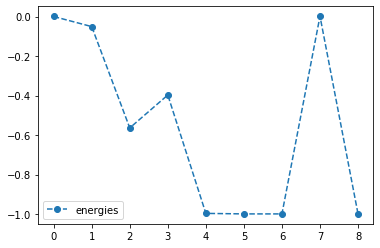

In [11]:
result.history.plot()

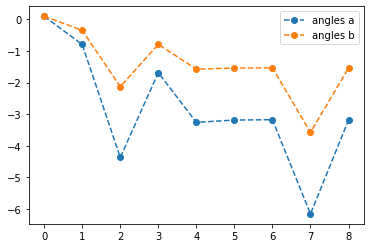

In [12]:
result.history.plot(property='angles', key=['a', 'b'])

# FAQ

## 1: How can I extract the parameters from a given circuit?

Call the 'extract_parameters' attribute and get back a dictionary of all Variables in the circuit

In [13]:
angles = U.extract_parameters()
angles

{'a': 0.0, 'b': 0.0}

## 2: How can I change the parameters of a given circuit?

You can call the 'update_parameters' function and pass down a dictionary with all angles you want to change

In [14]:
old_values = U.extract_parameters()
U.update_parameters(parameters={'a': 0.0})
U.extract_parameters()

{'a': 0.0, 'b': 0.0}

In [15]:
# set it back to before
U.update_parameters(old_values)
U.extract_parameters()

{'a': 0.0, 'b': 0.0}

## 3: How can I do measurement based simulation? Meaning no full wavefunction simulation?

Pass down the 'samples' keyword to simulate finite samples
See the later exercises to play around with sample number and optimization methods.

Feel free to play around with the number of samples 
Don't excpect miracles from the optimizer, you might need to hit return a few times or increase the number of samples.<br>Note that stochastic gradients are not yet supported
<br>Note also that we did not set the initial parameters, so we will start with all parameters set to 0 which is a stationary point in this example (full wavefunction simulation would get stuck, see also the exercise below).


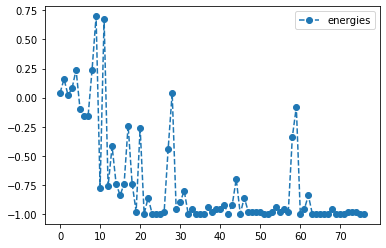

In [16]:
O = Objective(unitaries=U, observable=H)
result = scipy_optimizers.minimize(objective=O, samples=100, method="Powell")
result.history.plot('energies')

## 4: Which Simulator was used and how can I choose the simulator?

You can pass down the simulator to the optimizer by the simulator keyword (see below)
If no specific simulator was chosen by you that means the simulator is automatically picked. Which simulator is picked depends on what simulators you have installed and if you demanded a full wavefunction to be simulated or not.

You can check which simulators you have installed with the following

In [17]:
from openvqe import simulators
print(simulators.show_available_simulators())

Avaliable Simulators:
qiskit = True
cirq   = True
qulacs = True
pyquil = True



Here is how you would initialize a simulator and pass it down the optimizer.
The if statement is just to prevent your Ipython kernel from crashing when you have not installed the simulator
Feel free to change it to something you have installed

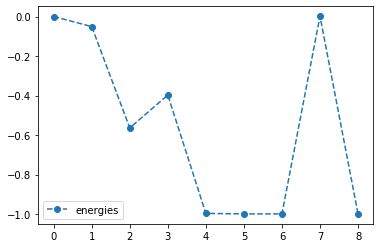

In [18]:
if simulators.HAS_CIRQ:
    O = Objective(unitaries=U, observable=H)
    result = scipy_optimizers.minimize(objective=O,
                                       initial_values=initial_values,
                                       simulator=simulators.SimulatorCirq)
    result.history.plot()

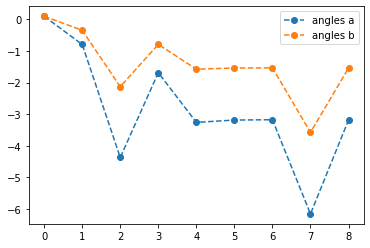

In [19]:
result.history.plot('angles')

# Exercises

See farther down for solutions

## Exercise 1

You can pass down initial_values to the optimizer in the same format as you can do it with the circuit (see above).
Figure out how to do that by checking out the documentation of the 'minimize' function.

## Exercise 2
Figure out which method the optimizer above used and how to use a different optimization method. To do so check out the documentation of the 'minimize' function

In [20]:
# hint
scipy_optimizers.available_methods()

['Nelder-Mead',
 'COBYLA',
 'Powell',
 'SLSQP',
 'L-BFGS-B',
 'BFGS',
 'CG',
 'dogleg',
 'TNC']

## Exercise 3
If you initialize both parameters to 0.0 you will directly hit a stationary point which causes the optimizer stop.
Find out how you can impose bounds on the variables in order to prevent the optimizer from hitting that point.

Again: Check the documentation of the 'minimize' function.

Note: Not all optimization methods of SciPy support bounds on the variables

Note: It is not enough to just restrict the point 0.0

# Solutions

## Exercise 1 & 2

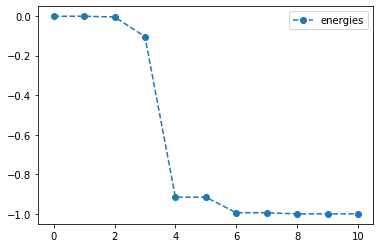

In [21]:
O = Objective(unitaries=U, observable=H)
result = scipy_optimizers.minimize(objective=O, method='TNC', maxiter=10, initial_values={'a':-0.2, 'b':-0.1})
result.history.plot()

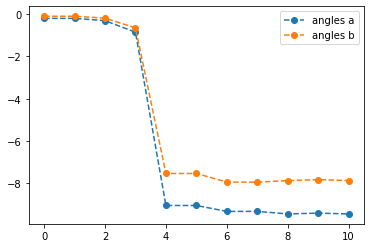

In [22]:
result.history.plot('angles')

## Exercise 3

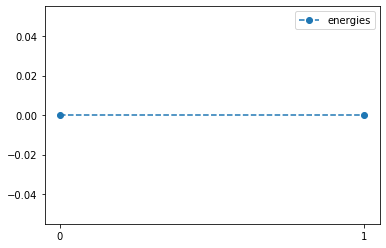

In [23]:
# this will get stuck (similar for other gradient based optimizers)
zeroes = {'a':0.0, 'b':0.0}
shift = 1.0
O = Objective(unitaries=U, observable=H)
result = scipy_optimizers.minimize(objective=O, method='TNC', initial_values=zeroes)
result.history.plot()

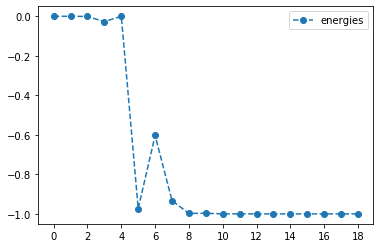

In [24]:
# bounding the variables to keep it away from the stationary point which occurs at 0 and is periodic in 2pi
# using negative values since that converges faster
zeroes = {'a':0.0, 'b':0.0}
shift = 1.0
bounds = {'a':(-2*numpy.pi+0.1, -0.1), 'b':(-2*numpy.pi+0.1, -0.1) }
O = Objective(unitaries=U, observable=H)
result = scipy_optimizers.minimize(objective=O, method='TNC', initial_values=zeroes, method_bounds=bounds)
result.history.plot()

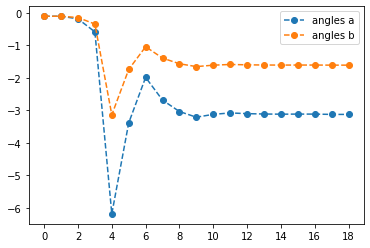

In [25]:
result.history.plot('angles')